In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from tqdm import tqdm
import json
import yaml
from shutil import copyfile
import matplotlib.pyplot as plt

random.seed(108)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!pwd

/kaggle/working


In [4]:
%mkdir Road_Sign_Dataset
%cd Road_Sign_Dataset
!mkdir annotations
!mkdir images

/kaggle/working/Road_Sign_Dataset


In [5]:
%cd /kaggle/working/Road_Sign_Dataset
!ls

/kaggle/working/Road_Sign_Dataset
annotations  images


In [6]:
%cd ..

/kaggle/working


# to delete all folders

In [ ]:
#!rm -R Road_Sign_Dataset
#!rm -R training

In [7]:
!cp -R /kaggle/input/tbx-11/TBX11K/annotations/xml/* /kaggle/working/Road_Sign_Dataset/annotations
!cp -R /kaggle/input/tbx-11/TBX11K/imgs/tb/* /kaggle/working/Road_Sign_Dataset/images

In [8]:
!pwd
!ls

/kaggle/working
Road_Sign_Dataset


In [9]:
# Assuming you're in the data folder
!cat /kaggle/working/Road_Sign_Dataset/annotations/tb0004.xml

<annotation>
	<filename>tb0004</filename>
	<segmented>0</segmented>
	<size>
		<width>1852</width>
		<height>2022</height>
	</size>
	<object>
		<name>ActiveTuberculosis</name>
		<pose>unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>469</xmin>
			<ymin>228</ymin>
			<xmax>890</xmax>
			<ymax>603</ymax>
		</bndbox>
	</object>
	<object>
		<name>ActiveTuberculosis</name>
		<pose>unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>1177</xmin>
			<ymin>317</ymin>
			<xmax>1503</xmax>
			<ymax>728</ymax>
		</bndbox>
	</object>
</annotation>


In [10]:
root = ET.parse('/kaggle/working/Road_Sign_Dataset/annotations/tb0026.xml').getroot()
root

<Element 'annotation' at 0x7a83101d5120>

In [11]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text + '.xml'
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [12]:
import os
os.remove('/kaggle/working/Road_Sign_Dataset/annotations/tb1199.xml')
os.remove('/kaggle/working/Road_Sign_Dataset/images/tb1199.png')

In [13]:
print(extract_info_from_xml('/kaggle/working/Road_Sign_Dataset/annotations/tb0004.xml'))

{'bboxes': [{'class': 'ActiveTuberculosis', 'xmin': 469, 'ymin': 228, 'xmax': 890, 'ymax': 603}, {'class': 'ActiveTuberculosis', 'xmin': 1177, 'ymin': 317, 'xmax': 1503, 'ymax': 728}], 'filename': 'tb0004.xml', 'image_size': (1852, 2022)}


In [ ]:
{'bboxes': [{'class': 'trafficlight', 'xmin': 20, 'ymin': 109, 'xmax': 81, 'ymax': 237}, {'class': 'trafficlight', 'xmin': 116, 'ymin': 162, 'xmax': 163, 'ymax': 272}, {'class': 'trafficlight', 'xmin': 189, 'ymin': 189, 'xmax': 233, 'ymax': 295}], 'filename': 'road4.png', 'image_size': (267, 400, 3)}


In [14]:
%cd /kaggle/working/Road_Sign_Dataset

/kaggle/working/Road_Sign_Dataset


In [ ]:
#!rm -R /kaggle/working/Road_Sign_Dataset/labels

In [15]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"ActiveTuberculosis": 0,
                           "ObsoletePulmonaryTuberculosis": 1}
                            #,
                           #"speedlimit": 2,
                           #"crosswalk": 3}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    num_class_0 = 0
    num_class_1 = 0
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
            
        if b["class"] == 'ActiveTuberculosis':
            num_class_0 = num_class_0 + 1
        else:
            num_class_1 = num_class_1 + 1
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_c = 3
        image_w, image_h = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
    
    #print(info_dict["filename"])
    # Name of the file which we have to save 
    save_file_name = os.path.join("annotations", info_dict["filename"].replace(".xml", ".txt"))
    
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))
    
    return num_class_0, num_class_1


In [ ]:
#annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "xml"]
#annotations.sort()
#annotations

In [16]:
# Get the annotations
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "xml"]
annotations.sort()
total_class_0 = 0 
total_class_1 = 0
# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    #print(info_dict)
    num_class_0, num_class_1 = convert_to_yolov5(info_dict)
    total_class_0 = total_class_0 +num_class_0
    total_class_1 = total_class_1 +num_class_1
print( " No of Active boxes ", total_class_0)
print( " No of Obsolete boxes ", total_class_1)    
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

100%|██████████| 799/799 [00:00<00:00, 4397.92it/s]

 No of Active boxes  972
 No of Obsolete boxes  239


In [19]:
len(os.listdir('annotations'))

1598

In [17]:
#{'bboxes': [{'class': 'ObsoletePulmonaryTuberculosis', 'xmin': 1446, 'ymin': 250, 'xmax': 2007, 'ymax': 1017}, {'class': 'ObsoletePulmonaryTuberculosis', 'xmin': 618, 'ymin': 391, 'xmax': 1177, 'ymax': 1013}], 'filename': 'tb0003', 'image_size': (2840, 2827)}

# Testing the annotations

In [ ]:
#annotations

In [20]:
annotation_file = random.choice(annotations)

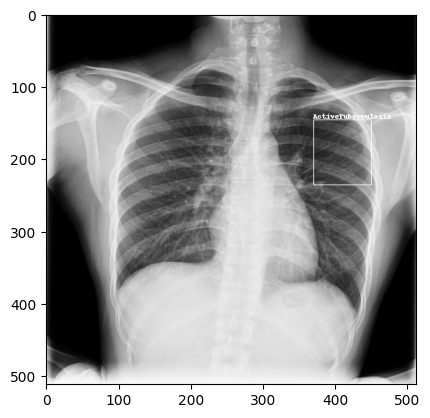

In [21]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)


# Partition the dataset

In [22]:
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]
#annotations

In [23]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)


In [ ]:
# Preparing the data and structure directories for Yolov5
#os.makedirs('/kaggle/working/training/images/train', exist_ok=True)
#os.makedirs('/kaggle/working/training/images/valid', exist_ok=True)
#
#os.makedirs('/kaggle/working/training/labels/train', exist_ok=True)
#os.makedirs('/kaggle/working/training/labels/valid', exist_ok=True)

In [24]:
%cd /kaggle/working/Road_Sign_Dataset
!pwd

/kaggle/working/Road_Sign_Dataset
/kaggle/working/Road_Sign_Dataset


In [25]:
# 
!mkdir images/train 
!mkdir images/val 
!mkdir images/test 

!mkdir annotations/train 
!mkdir annotations/val 
!mkdir annotations/test

In [26]:
!ls

annotations  images


In [27]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, '/kaggle/working/Road_Sign_Dataset/images/train')
move_files_to_folder(val_images, '/kaggle/working/Road_Sign_Dataset/images/val/')
move_files_to_folder(test_images, '/kaggle/working/Road_Sign_Dataset/images/test/')
move_files_to_folder(train_annotations, '/kaggle/working/Road_Sign_Dataset/annotations/train/')
move_files_to_folder(val_annotations, '/kaggle/working/Road_Sign_Dataset/annotations/val/')
move_files_to_folder(test_annotations, '/kaggle/working/Road_Sign_Dataset/annotations/test/')
!mv annotations labels
%cd ../

/kaggle/working


In [42]:
print(len(os.listdir('/kaggle/working/Road_Sign_Dataset/images/train')))
print(len(os.listdir('/kaggle/working/Road_Sign_Dataset/images/val/')))
print(len(os.listdir('/kaggle/working/Road_Sign_Dataset/images/test/')))

print(len(os.listdir('/kaggle/working/Road_Sign_Dataset/labels/train/')))
print(len(os.listdir('/kaggle/working/Road_Sign_Dataset/labels/val/')))
print(len(os.listdir('/kaggle/working/Road_Sign_Dataset/labels/test/')))

639
80
80
639
80
80


In [28]:
%cd /kaggle/working/Road_Sign_Dataset/
!ls

/kaggle/working/Road_Sign_Dataset
images	labels


In [29]:
!wget -P data/ https://gist.githubusercontent.com/ayooshkathuria/bcf7e3c929cbad445439c506dba6198d/raw/f437350c0c17c4eaa1e8657a5cb836e65d8aa08a/road_sign_data.yaml

--2023-10-13 15:10:36--  https://gist.githubusercontent.com/ayooshkathuria/bcf7e3c929cbad445439c506dba6198d/raw/f437350c0c17c4eaa1e8657a5cb836e65d8aa08a/road_sign_data.yaml
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220 [text/plain]
Saving to: ‘data/road_sign_data.yaml’

road_sign_data.yaml 100%[===================>]     220  --.-KB/s    in 0s      

2023-10-13 15:10:36 (8.42 MB/s) - ‘data/road_sign_data.yaml’ saved [220/220]



In [ ]:
%cd ..

In [ ]:
#!rm -R yolov5

In [30]:
# Let's install Yolov5 to exploring a wonderful trip 
%cd /kaggle/working
!git clone https://github.com/ultralytics/yolov5
%cd /kaggle/working/yolov5
%pip install -r requirements.txt

/kaggle/working
Cloning into 'yolov5'...
remote: Enumerating objects: 16003, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 16003 (delta 21), reused 20 (delta 13), pack-reused 15967
Receiving objects: 100% (16003/16003), 14.60 MiB | 26.98 MiB/s, done.
Resolving deltas: 100% (10987/10987), done.
/kaggle/working/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641.0/641.0 kB 15.5 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [39]:
print(len(os.listdir('/kaggle/working/Road_Sign_Dataset/images/train/ ')))

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/Road_Sign_Dataset/images/train/ '

In [ ]:
print(len(os.listdir('/kaggle/working/Road_Sign_Dataset/images/train')))
print(len(os.listdir('/kaggle/working/Road_Sign_Dataset/images/val/')))
print(len(os.listdir('/kaggle/working/Road_Sign_Dataset/images/test/')))

print(len(os.listdir('/kaggle/working/Road_Sign_Dataset/labels/train/')))
print(len(os.listdir('/kaggle/working/Road_Sign_Dataset/labels/val/')))
print(len(os.listdir('/kaggle/working/Road_Sign_Dataset/labels/test/')))

In [31]:
yamltext = """
train: /kaggle/working/Road_Sign_Dataset/images/train/ 
val:  /kaggle/working/Road_Sign_Dataset/images/val/
test: /kaggle/working/Road_Sign_Dataset/images/test/

# number of classes
nc: 2

# class names
names: ["ActiveTuberculosis","ObsoletePulmonaryTuberculosis"]

"""

with open("/kaggle/working/yolov5/data/tbx_data.yaml", 'w') as file:
    file.write(yamltext)

#%cat /kaggle/working/data/data.yaml


!cat /kaggle/working/yolov5/data/tbx_data.yaml


train: /kaggle/working/Road_Sign_Dataset/images/train/ 
val:  /kaggle/working/Road_Sign_Dataset/images/val/
test: /kaggle/working/Road_Sign_Dataset/images/test/

# number of classes
nc: 2

# class names
names: ["ActiveTuberculosis","ObsoletePulmonaryTuberculosis"]



In [32]:
!pip install wandb

In [33]:
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Run 1 - 30 Epochs Default**

In [ ]:
# For showing the example code, I only select yolov5s model and 1 epoch to run.
BATCH_SIZE = 16
EPOCHS = 30
MODEL = 'yolov5m.pt' # this specify the model for training, you can use yolov5s.pt, yolov5l.pt, yolov5x.pt, etc.

In [46]:
# GO TRAIN
!python train.py --batch {BATCH_SIZE} \
                 --epochs 30 \
                 --data data/tbx_data.yaml \
                 --weights {MODEL} \
                 --project yolov5_13Oct_30Ep_1\
                 --name yolov5_13Oct_30Ep_1

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: rachana4lg (rachmsupgradljmu). Use `wandb login --relogin` to force relogin
train: weights=yolov5m.pt, cfg=, data=data/tbx_data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5_13Oct_30Ep_1, name=yolov5_13Oct_30Ep_1, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 torch-2

# Run 2 40 Epochs

In [56]:
# For showing the example code, I only select yolov5s model and 1 epoch to run.
BATCH_SIZE = 16
EPOCHS = 40
MODEL = 'yolov5m.pt' # this specify the model for training, you can use yolov5s.pt, yolov5l.pt, yolov5x.pt, etc.

In [36]:
%cd yolov5
!pwd

[Errno 2] No such file or directory: 'yolov5'
/kaggle/working/yolov5
/kaggle/working/yolov5


In [57]:
# GO TRAIN
!python train.py --batch {BATCH_SIZE} \
                 --epochs 40 \
                 --data data/tbx_data.yaml \
                 --weights {MODEL} \
                 --project yolov5_13Oct_40EPOCHS_2\
                 --name yolov5_13Oct_40EPOCHS_2

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: rachana4lg (rachmsupgradljmu). Use `wandb login --relogin` to force relogin
train: weights=yolov5m.pt, cfg=, data=data/tbx_data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=40, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5_13Oct_40EPOCHS_2, name=yolov5_13Oct_40EPOCHS_2, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12

# Run 3 - 50 Epochs Default Settings

In [58]:
# For showing the example code, I only select yolov5s model and 1 epoch to run.
BATCH_SIZE = 16
EPOCHS = 50
MODEL = 'yolov5m.pt'

In [59]:
# GO TRAIN
!python train.py --batch {BATCH_SIZE} \
                 --epochs 50 \
                 --data data/tbx_data.yaml \
                 --weights {MODEL} \
                 --project yolov5_13Oct_50EPOCHS_2\
                 --name yolov5_13Oct_50EPOCHS_2

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: rachana4lg (rachmsupgradljmu). Use `wandb login --relogin` to force relogin
train: weights=yolov5m.pt, cfg=, data=data/tbx_data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5_13Oct_50EPOCHS_2, name=yolov5_13Oct_50EPOCHS_2, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12

In [60]:
test

NameError: name 'test' is not defined

# Run 4 - Custom Albumentations @50 Epochs

In [48]:
augmentations_template = '''

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license
"""
Image augmentation functions
"""

import math
import random

import cv2
import numpy as np
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from utils.general import LOGGER, check_version, colorstr, resample_segments, segment2box, xywhn2xyxy
from utils.metrics import bbox_ioa

IMAGENET_MEAN = 0.485, 0.456, 0.406  # RGB mean
IMAGENET_STD = 0.229, 0.224, 0.225  # RGB standard deviation


class Albumentations:
    # YOLOv5 Albumentations class (optional, only used if package is installed)
    def __init__(self, size=640):
        self.transform = None
        prefix = colorstr('albumentations: ')
        try:
            import albumentations as A
            check_version(A.__version__, '1.0.3', hard=True)  # version requirement

            T = [
                A.RandomResizedCrop(height=size, width=size, scale=(0.8, 1.0), ratio=(0.9, 1.11), p=0.0),
                #A.Blur(p=0.01),   #6/9
                #A.MedianBlur(p=0.01),  #6/9
                #A.ToGray(p=0.01),  #6/9
                A.HorizontalFlip(p=0.5),   # 6/9
                A.Sharpen(alpha=(0.3), lightness=(0.2),p=0.3),  # 6/9
                A.CLAHE(p=0.01),
                A.RandomBrightnessContrast(p=0.2),  # changed from 0 to 0.2
                A.RandomGamma(p=0.0),
                A.ImageCompression(quality_lower=75, p=0.0)]  # transforms
            self.transform = A.Compose(T, bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

            LOGGER.info(prefix + ', '.join(f'{x}'.replace('always_apply=False, ', '') for x in T if x.p))
        except ImportError:  # package not installed, skip
            pass
        except Exception as e:
            LOGGER.info(f'{prefix}{e}')

    def __call__(self, im, labels, p=1.0):
        if self.transform and random.random() < p:
            new = self.transform(image=im, bboxes=labels[:, 1:], class_labels=labels[:, 0])  # transformed
            im, labels = new['image'], np.array([[c, *b] for c, b in zip(new['class_labels'], new['bboxes'])])
        return im, labels


def normalize(x, mean=IMAGENET_MEAN, std=IMAGENET_STD, inplace=False):
    # Denormalize RGB images x per ImageNet stats in BCHW format, i.e. = (x - mean) / std
    return TF.normalize(x, mean, std, inplace=inplace)


def denormalize(x, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    # Denormalize RGB images x per ImageNet stats in BCHW format, i.e. = x * std + mean
    for i in range(3):
        x[:, i] = x[:, i] * std[i] + mean[i]
    return x


def augment_hsv(im, hgain=0.5, sgain=0.5, vgain=0.5):
    # HSV color-space augmentation
    if hgain or sgain or vgain:
        r = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1  # random gains
        hue, sat, val = cv2.split(cv2.cvtColor(im, cv2.COLOR_BGR2HSV))
        dtype = im.dtype  # uint8

        x = np.arange(0, 256, dtype=r.dtype)
        lut_hue = ((x * r[0]) % 180).astype(dtype)
        lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
        lut_val = np.clip(x * r[2], 0, 255).astype(dtype)

        im_hsv = cv2.merge((cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val)))
        cv2.cvtColor(im_hsv, cv2.COLOR_HSV2BGR, dst=im)  # no return needed


def hist_equalize(im, clahe=True, bgr=False):
    # Equalize histogram on BGR image 'im' with im.shape(n,m,3) and range 0-255
    yuv = cv2.cvtColor(im, cv2.COLOR_BGR2YUV if bgr else cv2.COLOR_RGB2YUV)
    if clahe:
        c = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        yuv[:, :, 0] = c.apply(yuv[:, :, 0])
    else:
        yuv[:, :, 0] = cv2.equalizeHist(yuv[:, :, 0])  # equalize Y channel histogram
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR if bgr else cv2.COLOR_YUV2RGB)  # convert YUV image to RGB


def replicate(im, labels):
    # Replicate labels
    h, w = im.shape[:2]
    boxes = labels[:, 1:].astype(int)
    x1, y1, x2, y2 = boxes.T
    s = ((x2 - x1) + (y2 - y1)) / 2  # side length (pixels)
    for i in s.argsort()[:round(s.size * 0.5)]:  # smallest indices
        x1b, y1b, x2b, y2b = boxes[i]
        bh, bw = y2b - y1b, x2b - x1b
        yc, xc = int(random.uniform(0, h - bh)), int(random.uniform(0, w - bw))  # offset x, y
        x1a, y1a, x2a, y2a = [xc, yc, xc + bw, yc + bh]
        im[y1a:y2a, x1a:x2a] = im[y1b:y2b, x1b:x2b]  # im4[ymin:ymax, xmin:xmax]
        labels = np.append(labels, [[labels[i, 0], x1a, y1a, x2a, y2a]], axis=0)

    return im, labels


def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)


def random_perspective(im,
                       targets=(),
                       segments=(),
                       degrees=10,
                       translate=.1,
                       scale=.1,
                       shear=10,
                       perspective=0.0,
                       border=(0, 0)):
    # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=(-10, 10))
    # targets = [cls, xyxy]

    height = im.shape[0] + border[0] * 2  # shape(h,w,c)
    width = im.shape[1] + border[1] * 2

    # Center
    C = np.eye(3)
    C[0, 2] = -im.shape[1] / 2  # x translation (pixels)
    C[1, 2] = -im.shape[0] / 2  # y translation (pixels)

    # Perspective
    P = np.eye(3)
    P[2, 0] = random.uniform(-perspective, perspective)  # x perspective (about y)
    P[2, 1] = random.uniform(-perspective, perspective)  # y perspective (about x)

    # Rotation and Scale
    R = np.eye(3)
    a = random.uniform(-degrees, degrees)
    # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
    s = random.uniform(1 - scale, 1 + scale)
    # s = 2 ** random.uniform(-scale, scale)
    R[:2] = cv2.getRotationMatrix2D(angle=a, center=(0, 0), scale=s)

    # Shear
    S = np.eye(3)
    S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
    S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

    # Translation
    T = np.eye(3)
    T[0, 2] = random.uniform(0.5 - translate, 0.5 + translate) * width  # x translation (pixels)
    T[1, 2] = random.uniform(0.5 - translate, 0.5 + translate) * height  # y translation (pixels)

    # Combined rotation matrix
    M = T @ S @ R @ P @ C  # order of operations (right to left) is IMPORTANT
    if (border[0] != 0) or (border[1] != 0) or (M != np.eye(3)).any():  # image changed
        if perspective:
            im = cv2.warpPerspective(im, M, dsize=(width, height), borderValue=(114, 114, 114))
        else:  # affine
            im = cv2.warpAffine(im, M[:2], dsize=(width, height), borderValue=(114, 114, 114))

    # Visualize
    # import matplotlib.pyplot as plt
    # ax = plt.subplots(1, 2, figsize=(12, 6))[1].ravel()
    # ax[0].imshow(im[:, :, ::-1])  # base
    # ax[1].imshow(im2[:, :, ::-1])  # warped

    # Transform label coordinates
    n = len(targets)
    if n:
        use_segments = any(x.any() for x in segments) and len(segments) == n
        new = np.zeros((n, 4))
        if use_segments:  # warp segments
            segments = resample_segments(segments)  # upsample
            for i, segment in enumerate(segments):
                xy = np.ones((len(segment), 3))
                xy[:, :2] = segment
                xy = xy @ M.T  # transform
                xy = xy[:, :2] / xy[:, 2:3] if perspective else xy[:, :2]  # perspective rescale or affine

                # clip
                new[i] = segment2box(xy, width, height)

        else:  # warp boxes
            xy = np.ones((n * 4, 3))
            xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
            xy = xy @ M.T  # transform
            xy = (xy[:, :2] / xy[:, 2:3] if perspective else xy[:, :2]).reshape(n, 8)  # perspective rescale or affine

            # create new boxes
            x = xy[:, [0, 2, 4, 6]]
            y = xy[:, [1, 3, 5, 7]]
            new = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

            # clip
            new[:, [0, 2]] = new[:, [0, 2]].clip(0, width)
            new[:, [1, 3]] = new[:, [1, 3]].clip(0, height)

        # filter candidates
        i = box_candidates(box1=targets[:, 1:5].T * s, box2=new.T, area_thr=0.01 if use_segments else 0.10)
        targets = targets[i]
        targets[:, 1:5] = new[i]

    return im, targets


def copy_paste(im, labels, segments, p=0.5):
    # Implement Copy-Paste augmentation https://arxiv.org/abs/2012.07177, labels as nx5 np.array(cls, xyxy)
    n = len(segments)
    if p and n:
        h, w, c = im.shape  # height, width, channels
        im_new = np.zeros(im.shape, np.uint8)
        for j in random.sample(range(n), k=round(p * n)):
            l, s = labels[j], segments[j]
            box = w - l[3], l[2], w - l[1], l[4]
            ioa = bbox_ioa(box, labels[:, 1:5])  # intersection over area
            if (ioa < 0.30).all():  # allow 30% obscuration of existing labels
                labels = np.concatenate((labels, [[l[0], *box]]), 0)
                segments.append(np.concatenate((w - s[:, 0:1], s[:, 1:2]), 1))
                cv2.drawContours(im_new, [segments[j].astype(np.int32)], -1, (1, 1, 1), cv2.FILLED)

        result = cv2.flip(im, 1)  # augment segments (flip left-right)
        i = cv2.flip(im_new, 1).astype(bool)
        im[i] = result[i]  # cv2.imwrite('debug.jpg', im)  # debug

    return im, labels, segments


def cutout(im, labels, p=0.5):
    # Applies image cutout augmentation https://arxiv.org/abs/1708.04552
    if random.random() < p:
        h, w = im.shape[:2]
        scales = [0.5] * 1 + [0.25] * 2 + [0.125] * 4 + [0.0625] * 8 + [0.03125] * 16  # image size fraction
        for s in scales:
            mask_h = random.randint(1, int(h * s))  # create random masks
            mask_w = random.randint(1, int(w * s))

            # box
            xmin = max(0, random.randint(0, w) - mask_w // 2)
            ymin = max(0, random.randint(0, h) - mask_h // 2)
            xmax = min(w, xmin + mask_w)
            ymax = min(h, ymin + mask_h)

            # apply random color mask
            im[ymin:ymax, xmin:xmax] = [random.randint(64, 191) for _ in range(3)]

            # return unobscured labels
            if len(labels) and s > 0.03:
                box = np.array([xmin, ymin, xmax, ymax], dtype=np.float32)
                ioa = bbox_ioa(box, xywhn2xyxy(labels[:, 1:5], w, h))  # intersection over area
                labels = labels[ioa < 0.60]  # remove >60% obscured labels

    return labels


def mixup(im, labels, im2, labels2):
    # Applies MixUp augmentation https://arxiv.org/pdf/1710.09412.pdf
    r = np.random.beta(32.0, 32.0)  # mixup ratio, alpha=beta=32.0
    im = (im * r + im2 * (1 - r)).astype(np.uint8)
    labels = np.concatenate((labels, labels2), 0)
    return im, labels


def box_candidates(box1, box2, wh_thr=2, ar_thr=100, area_thr=0.1, eps=1e-16):  # box1(4,n), box2(4,n)
    # Compute candidate boxes: box1 before augment, box2 after augment, wh_thr (pixels), aspect_ratio_thr, area_ratio
    w1, h1 = box1[2] - box1[0], box1[3] - box1[1]
    w2, h2 = box2[2] - box2[0], box2[3] - box2[1]
    ar = np.maximum(w2 / (h2 + eps), h2 / (w2 + eps))  # aspect ratio
    return (w2 > wh_thr) & (h2 > wh_thr) & (w2 * h2 / (w1 * h1 + eps) > area_thr) & (ar < ar_thr)  # candidates


def classify_albumentations(
        augment=True,
        size=224,
        scale=(0.08, 1.0),
        ratio=(0.75, 1.0 / 0.75),  # 0.75, 1.33
        hflip=0.5,
        vflip=0.0,
        jitter=0.4,
        mean=IMAGENET_MEAN,
        std=IMAGENET_STD,
        auto_aug=False):
    # YOLOv5 classification Albumentations (optional, only used if package is installed)
    prefix = colorstr('albumentations: ')
    try:
        import albumentations as A
        from albumentations.pytorch import ToTensorV2
        check_version(A.__version__, '1.0.3', hard=True)  # version requirement
        if augment:  # Resize and crop
            T = [A.RandomResizedCrop(height=size, width=size, scale=scale, ratio=ratio)]
            if auto_aug:
                # TODO: implement AugMix, AutoAug & RandAug in albumentation
                LOGGER.info(f'{prefix}auto augmentations are currently not supported')
            else:
                if hflip > 0:
                    T += [A.HorizontalFlip(p=hflip)]
                if vflip > 0:
                    T += [A.VerticalFlip(p=vflip)]
                if jitter > 0:
                    color_jitter = (float(jitter), ) * 3  # repeat value for brightness, contrast, satuaration, 0 hue
                    T += [A.ColorJitter(*color_jitter, 0)]
        else:  # Use fixed crop for eval set (reproducibility)
            T = [A.SmallestMaxSize(max_size=size), A.CenterCrop(height=size, width=size)]
        T += [A.Normalize(mean=mean, std=std), ToTensorV2()]  # Normalize and convert to Tensor
        LOGGER.info(prefix + ', '.join(f'{x}'.replace('always_apply=False, ', '') for x in T if x.p))
        return A.Compose(T)

    except ImportError:  # package not installed, skip
        LOGGER.warning(f'{prefix}⚠️ not found, install with `pip install albumentations` (recommended)')
    except Exception as e:
        LOGGER.info(f'{prefix}{e}')


def classify_transforms(size=224):
    # Transforms to apply if albumentations not installed
    assert isinstance(size, int), f'ERROR: classify_transforms size {size} must be integer, not (list, tuple)'
    # T.Compose([T.ToTensor(), T.Resize(size), T.CenterCrop(size), T.Normalize(IMAGENET_MEAN, IMAGENET_STD)])
    return T.Compose([CenterCrop(size), ToTensor(), T.Normalize(IMAGENET_MEAN, IMAGENET_STD)])


class LetterBox:
    # YOLOv5 LetterBox class for image preprocessing, i.e. T.Compose([LetterBox(size), ToTensor()])
    def __init__(self, size=(640, 640), auto=False, stride=32):
        super().__init__()
        self.h, self.w = (size, size) if isinstance(size, int) else size
        self.auto = auto  # pass max size integer, automatically solve for short side using stride
        self.stride = stride  # used with auto

    def __call__(self, im):  # im = np.array HWC
        imh, imw = im.shape[:2]
        r = min(self.h / imh, self.w / imw)  # ratio of new/old
        h, w = round(imh * r), round(imw * r)  # resized image
        hs, ws = (math.ceil(x / self.stride) * self.stride for x in (h, w)) if self.auto else self.h, self.w
        top, left = round((hs - h) / 2 - 0.1), round((ws - w) / 2 - 0.1)
        im_out = np.full((self.h, self.w, 3), 114, dtype=im.dtype)
        im_out[top:top + h, left:left + w] = cv2.resize(im, (w, h), interpolation=cv2.INTER_LINEAR)
        return im_out


class CenterCrop:
    # YOLOv5 CenterCrop class for image preprocessing, i.e. T.Compose([CenterCrop(size), ToTensor()])
    def __init__(self, size=640):
        super().__init__()
        self.h, self.w = (size, size) if isinstance(size, int) else size

    def __call__(self, im):  # im = np.array HWC
        imh, imw = im.shape[:2]
        m = min(imh, imw)  # min dimension
        top, left = (imh - m) // 2, (imw - m) // 2
        return cv2.resize(im[top:top + m, left:left + m], (self.w, self.h), interpolation=cv2.INTER_LINEAR)


class ToTensor:
    # YOLOv5 ToTensor class for image preprocessing, i.e. T.Compose([LetterBox(size), ToTensor()])
    def __init__(self, half=False):
        super().__init__()
        self.half = half

    def __call__(self, im):  # im = np.array HWC in BGR order
        im = np.ascontiguousarray(im.transpose((2, 0, 1))[::-1])  # HWC to CHW -> BGR to RGB -> contiguous
        im = torch.from_numpy(im)  # to torch
        im = im.half() if self.half else im.float()  # uint8 to fp16/32
        im /= 255.0  # 0-255 to 0.0-1.0
        return im
    
'''

#augmentations = Template(augmentations_template).substitute(
    #albumentations = ALBUMENTATIONS,
#)

with open('/kaggle/working/yolov5/utils/augmentations.py', 'w') as f:
    f.write(augmentations_template)

!cat /kaggle/working/yolov5/utils/augmentations.py



# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license
"""
Image augmentation functions
"""

import math
import random

import cv2
import numpy as np
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from utils.general import LOGGER, check_version, colorstr, resample_segments, segment2box, xywhn2xyxy
from utils.metrics import bbox_ioa

IMAGENET_MEAN = 0.485, 0.456, 0.406  # RGB mean
IMAGENET_STD = 0.229, 0.224, 0.225  # RGB standard deviation


class Albumentations:
    # YOLOv5 Albumentations class (optional, only used if package is installed)
    def __init__(self, size=640):
        self.transform = None
        prefix = colorstr('albumentations: ')
        try:
            import albumentations as A
            check_version(A.__version__, '1.0.3', hard=True)  # version requirement

            T = [
                A.RandomResizedCrop(height=size, width=size, scale=(0.8, 1.0), ratio=(0.9, 1.11), p=0.0),
                #A.Blur(p=0.01),   #6/9
 

In [49]:
# For showing the example code, I only select yolov5s model and 1 epoch to run.
BATCH_SIZE = 16
EPOCHS = 50
MODEL = 'yolov5m.pt'

# GO TRAIN
!python train.py --batch {BATCH_SIZE} \
                 --epochs 50 \
                 --data data/tbx_data.yaml \
                 --weights {MODEL} \
                 --project yolov5_13Oct_CustomAlb_50EPOCHS\
                 --name yolov5_13Oct_CustomAlb_50EPOCHS


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: rachana4lg (rachmsupgradljmu). Use `wandb login --relogin` to force relogin
train: weights=yolov5m.pt, cfg=, data=data/tbx_data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5_13Oct_CustomAlb_50EPOCHS, name=yolov5_13Oct_CustomAlb_50EPOCHS, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-226-gdd9e33

In [61]:
test

NameError: name 'test' is not defined

# Run 5 - yolo large model

In [51]:
# For showing the example code, I only select yolov5s model and 1 epoch to run.
BATCH_SIZE = 16
EPOCHS = 50
MODEL = 'yolov5l.pt'

In [53]:
# GO TRAIN
!python train.py --batch {BATCH_SIZE} \
                 --epochs 50 \
                 --data data/tbx_data.yaml \
                 --weights {MODEL} \
                 --project yolov5l_13Oct_50EPOCHS\
                 --name yolov5l_13Oct_50EPOCHS



wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: rachana4lg (rachmsupgradljmu). Use `wandb login --relogin` to force relogin
train: weights=yolov5l.pt, cfg=, data=data/tbx_data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5l_13Oct_50EPOCHS, name=yolov5l_13Oct_50EPOCHS, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 t

# Run 6 Default Settings @ 100 Epochs

In [ ]:
# For showing the example code, I only select yolov5s model and 1 epoch to run.
BATCH_SIZE = 16
EPOCHS = 100
MODEL = 'yolov5m.pt'

# GO TRAIN
!python train.py --batch {BATCH_SIZE} \
                 --epochs 100 \
                 --data data/tbx_data.yaml \
                 --weights {MODEL} \
                 --project yolov5_13Oct_100EPOCHS\
                 --name yolov5_100EPOCHS

# Inference

In [62]:
%cd /kaggle/working/yolov5

/kaggle/working/yolov5


# Run 1- Defaut Settings 30 Epochs

In [75]:
MODEL_PATH ='/kaggle/working/yolov5/yolov5_13Oct_30Ep_1/yolov5_13Oct_30Ep_12/weights/best.pt'
VALID_PATH = '/kaggle/working/Road_Sign_Dataset/images/test/'

# Let's begin the amazing time to detect the cowboy outfits objects
!python detect.py --weights {MODEL_PATH} \
                  --source {VALID_PATH} \
                  --conf 0.50 \
                  --iou-thres 0.5 \
                  --save-txt \
                  --save-conf \
                  --augment

detect: weights=['/kaggle/working/yolov5/yolov5_13Oct_30Ep_1/yolov5_13Oct_30Ep_12/weights/best.pt'], source=/kaggle/working/Road_Sign_Dataset/images/test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.5, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
image 1/80 /kaggle/working/Road_Sign_Dataset/images/test/tb0015.png: 640x640 1 ActiveTuberculosis, 88.3ms
image 2/80 /kaggle/working/Road_Sign_Dataset/images/test/tb0027.png: 640x640 (no detections), 32.3ms
image 3/80 /kaggle/working/Road_Sign_Dataset/

In [73]:
!python val.py --data /kaggle/working/yolov5/data/tbx_data.yaml --img 512 --weights {MODEL_PATH}  --task val

val: data=/kaggle/working/yolov5/data/tbx_data.yaml, weights=['/kaggle/working/yolov5/yolov5_13Oct_30Ep_1/yolov5_13Oct_30Ep_12/weights/best.pt'], batch_size=32, imgsz=512, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
val: Scanning /kaggle/working/Road_Sign_Dataset/labels/val.cache... 80 images, 0
                 Class     Images  Instances          P          R      mAP50   
                   all         80        113      0.544      0.497      0.492      0.238
    ActiveTuberculosis         80         98      0.681      0.719      0.693      0.327
ObsoletePulmonaryTuberculosis         80   

# Run 2- Default Settings 40 Epochs

In [74]:
MODEL_PATH ='/kaggle/working/yolov5/yolov5_13Oct_40EPOCHS_2/yolov5_13Oct_40EPOCHS_2/weights/best.pt'
VALID_PATH = '/kaggle/working/Road_Sign_Dataset/images/test/'


# Let's begin the amazing time to detect the cowboy outfits objects
!python detect.py --weights {MODEL_PATH} \
                  --source {VALID_PATH} \
                  --conf 0.50 \
                  --iou-thres 0.5 \
                  --save-txt \
                  --save-conf \
                  --augment

detect: weights=['/kaggle/working/yolov5/yolov5_13Oct_40EPOCHS_2/yolov5_13Oct_40EPOCHS_2/weights/best.pt'], source=/kaggle/working/Road_Sign_Dataset/images/test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.5, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
image 1/80 /kaggle/working/Road_Sign_Dataset/images/test/tb0015.png: 640x640 1 ActiveTuberculosis, 88.9ms
image 2/80 /kaggle/working/Road_Sign_Dataset/images/test/tb0027.png: 640x640 (no detections), 32.0ms
image 3/80 /kaggle/working/Road_Sign_D

In [77]:
!python val.py --data /kaggle/working/yolov5/data/tbx_data.yaml --img 512 --weights {MODEL_PATH}  --task val

val: data=/kaggle/working/yolov5/data/tbx_data.yaml, weights=['/kaggle/working/yolov5/yolov5_13Oct_40EPOCHS_2/yolov5_13Oct_40EPOCHS_2/weights/best.pt'], batch_size=32, imgsz=512, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
val: Scanning /kaggle/working/Road_Sign_Dataset/labels/val.cache... 80 images, 0
                 Class     Images  Instances          P          R      mAP50   
                   all         80        113      0.729      0.503      0.586       0.27
    ActiveTuberculosis         80         98      0.774      0.673      0.743      0.333
ObsoletePulmonaryTuberculosis       

# Run 3- Default Settings 50 Epochs


In [78]:

MODEL_PATH ='/kaggle/working/yolov5/yolov5_13Oct_50EPOCHS_2/yolov5_13Oct_50EPOCHS_2/weights/best.pt'
VALID_PATH = '/kaggle/working/Road_Sign_Dataset/images/test/'


# Let's begin the amazing time to detect the cowboy outfits objects
!python detect.py --weights {MODEL_PATH} \
                  --source {VALID_PATH} \
                  --conf 0.50 \
                  --iou-thres 0.5 \
                  --save-txt \
                  --save-conf \
                  --augment



detect: weights=['/kaggle/working/yolov5/yolov5_13Oct_50EPOCHS_2/yolov5_13Oct_50EPOCHS_2/weights/best.pt'], source=/kaggle/working/Road_Sign_Dataset/images/test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.5, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
image 1/80 /kaggle/working/Road_Sign_Dataset/images/test/tb0015.png: 640x640 1 ActiveTuberculosis, 89.7ms
image 2/80 /kaggle/working/Road_Sign_Dataset/images/test/tb0027.png: 640x640 1 ActiveTuberculosis, 32.0ms
image 3/80 /kaggle/working/Road_S

In [79]:
!python val.py --data /kaggle/working/yolov5/data/tbx_data.yaml --img 512 --weights {MODEL_PATH}  --task val

val: data=/kaggle/working/yolov5/data/tbx_data.yaml, weights=['/kaggle/working/yolov5/yolov5_13Oct_50EPOCHS_2/yolov5_13Oct_50EPOCHS_2/weights/best.pt'], batch_size=32, imgsz=512, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
val: Scanning /kaggle/working/Road_Sign_Dataset/labels/val.cache... 80 images, 0
                 Class     Images  Instances          P          R      mAP50   
                   all         80        113      0.731       0.59      0.655      0.257
    ActiveTuberculosis         80         98      0.795      0.713       0.77       0.33
ObsoletePulmonaryTuberculosis       

# Run 4- Custom Albumentations @40 Epochs

In [80]:
MODEL_PATH ='/kaggle/working/yolov5/yolov5_13Oct_CustomAlb_50EPOCHS/yolov5_13Oct_CustomAlb_50EPOCHS/weights/best.pt'
VALID_PATH = '/kaggle/working/Road_Sign_Dataset/images/test/'


# Let's begin the amazing time to detect the cowboy outfits objects
!python detect.py --weights {MODEL_PATH} \
                  --source {VALID_PATH} \
                  --conf 0.50 \
                  --iou-thres 0.5 \
                  --save-txt \
                  --save-conf \
                  --augment


detect: weights=['/kaggle/working/yolov5/yolov5_13Oct_CustomAlb_50EPOCHS/yolov5_13Oct_CustomAlb_50EPOCHS/weights/best.pt'], source=/kaggle/working/Road_Sign_Dataset/images/test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.5, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
image 1/80 /kaggle/working/Road_Sign_Dataset/images/test/tb0015.png: 640x640 1 ActiveTuberculosis, 125.4ms
image 2/80 /kaggle/working/Road_Sign_Dataset/images/test/tb0027.png: 640x640 1 ActiveTuberculosis, 32.2ms
image 3/80 /kagg

In [81]:
!python val.py --data /kaggle/working/yolov5/data/tbx_data.yaml --img 512 --weights {MODEL_PATH}  --task val

val: data=/kaggle/working/yolov5/data/tbx_data.yaml, weights=['/kaggle/working/yolov5/yolov5_13Oct_CustomAlb_50EPOCHS/yolov5_13Oct_CustomAlb_50EPOCHS/weights/best.pt'], batch_size=32, imgsz=512, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
val: Scanning /kaggle/working/Road_Sign_Dataset/labels/val.cache... 80 images, 0
                 Class     Images  Instances          P          R      mAP50   
                   all         80        113      0.786      0.696      0.699      0.308
    ActiveTuberculosis         80         98       0.81      0.724      0.771      0.365
ObsoletePulmonaryTub

# Run 5- Custom Albumentations Yolo Large

In [ ]:
MODEL_PATH ='/kaggle/working/yolov5/yolov5_13Oct_50EPOCHS_2/yolov5_13Oct_50EPOCHS_2/weights/best.pt'
VALID_PATH = '/kaggle/working/Road_Sign_Dataset/images/test/'


# Let's begin the amazing time to detect the cowboy outfits objects
!python detect.py --weights {MODEL_PATH} \
                  --source {VALID_PATH} \
                  --conf 0.50 \
                  --iou-thres 0.5 \
                  --save-txt \
                  --save-conf \
                  --augment

In [ ]:
!python val.py --data /kaggle/working/yolov5/data/tbx_data.yaml --img 512 --weights {MODEL_PATH}  --task val

# Run 6- Custom Albumentations Yolo Large

In [82]:
MODEL_PATH ='/kaggle/working/yolov5/yolov5l_13Oct_50EPOCHS/yolov5l_13Oct_50EPOCHS/weights/best.pt'
VALID_PATH = '/kaggle/working/Road_Sign_Dataset/images/test/'


# Let's begin the amazing time to detect the cowboy outfits objects
!python detect.py --weights {MODEL_PATH} \
                  --source {VALID_PATH} \
                  --conf 0.50 \
                  --iou-thres 0.5 \
                  --save-txt \
                  --save-conf \
                  --augment

detect: weights=['/kaggle/working/yolov5/yolov5l_13Oct_50EPOCHS/yolov5l_13Oct_50EPOCHS/weights/best.pt'], source=/kaggle/working/Road_Sign_Dataset/images/test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.5, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 267 layers, 46113663 parameters, 0 gradients, 107.7 GFLOPs
image 1/80 /kaggle/working/Road_Sign_Dataset/images/test/tb0015.png: 640x640 1 ActiveTuberculosis, 93.8ms
image 2/80 /kaggle/working/Road_Sign_Dataset/images/test/tb0027.png: 640x640 (no detections), 54.0ms
image 3/80 /kaggle/working/Road_Sign_Da

In [83]:
!python val.py --data /kaggle/working/yolov5/data/tbx_data.yaml --img 512 --weights {MODEL_PATH}  --task val

val: data=/kaggle/working/yolov5/data/tbx_data.yaml, weights=['/kaggle/working/yolov5/yolov5l_13Oct_50EPOCHS/yolov5l_13Oct_50EPOCHS/weights/best.pt'], batch_size=32, imgsz=512, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 267 layers, 46113663 parameters, 0 gradients, 107.7 GFLOPs
val: Scanning /kaggle/working/Road_Sign_Dataset/labels/val.cache... 80 images, 0
                 Class     Images  Instances          P          R      mAP50   
                   all         80        113      0.781      0.625      0.697       0.31
    ActiveTuberculosis         80         98      0.853      0.651      0.775       0.38
ObsoletePulmonaryTuberculosis        

In [84]:
# If you have run more than one times of detect.py, 
# the name of 'exp' in the path will be changed for storing the detecting results.
PRED_PATH = '/kaggle/working/yolov5/runs/detect/exp8/'

# list our prediction files path
prediction_files = os.listdir(PRED_PATH)
print('Number of test images with detections: ', len(prediction_files))

Number of test images with detections:  81


In [ ]:
Image.open('/kaggle/working/Road_Sign_Dataset/images/test/tb1170.png')

In [ ]:
%cd /kaggle/working/yolov5/runs/detect/exp5/
!ls

In [ ]:
Image.open('/kaggle/working/yolov5/runs/detect/exp/tb0950.png')

# End SMOTE

In [ ]:
!mkdir images/train 
!mkdir images/val 
!mkdir images/test 

!mkdir annotations/train 
!mkdir annotations/val 
!mkdir annotations/test

In [ ]:
len(os.listdir('/kaggle/working/Road_Sign_Dataset/images/train'))
#len(os.listdir('/kaggle/working/Road_Sign_Dataset/images/test'))
#len(os.listdir('/kaggle/working/Road_Sign_Dataset/images/val'))

In [ ]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, '/kaggle/working/Road_Sign_Dataset/images/train')
move_files_to_folder(val_images, '/kaggle/working/Road_Sign_Dataset/images/val/')
move_files_to_folder(test_images, '/kaggle/working/Road_Sign_Dataset/images/test/')
move_files_to_folder(train_annotations, '/kaggle/working/Road_Sign_Dataset/annotations/train/')
move_files_to_folder(val_annotations, '/kaggle/working/Road_Sign_Dataset/annotations/val/')
move_files_to_folder(test_annotations, '/kaggle/working/Road_Sign_Dataset/annotations/test/')
!mv annotations labels
%cd ../

In [ ]:
%cd /kaggle/working/Road_Sign_Dataset/
!ls

In [ ]:
len(os.listdir('/kaggle/working/Road_Sign_Dataset/labels/train/'))


In [ ]:
!wget -P data/ https://gist.githubusercontent.com/ayooshkathuria/bcf7e3c929cbad445439c506dba6198d/raw/f437350c0c17c4eaa1e8657a5cb836e65d8aa08a/road_sign_data.yaml


# INSTALL

In [ ]:
!pwd

In [ ]:
!git clone https://github.com/WongKinYiu/yolov7.git  #&> /dev/null

In [ ]:
%cd yolov7

In [ ]:
!pip install -r requirements.txt &> /dev/null

In [ ]:
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6e.pt

In [ ]:
!wget https://raw.githubusercontent.com/tkeldenich/How_to_use_YOLOv7_Tutorial/main/man_cafe.jpg

In [ ]:
from PIL import Image
im = Image.open('man_cafe.jpg')
im

In [ ]:
!python detect.py --weights yolov7-e6e.pt --source ./man_cafe.jpg

In [ ]:
im_res1 = Image.open('./runs/detect/exp/man_cafe.jpg')
im_res1

In [ ]:
!python detect.py --weights yolov7-e6e.pt --conf 0.60 --img-size 640 --source ./man_cafe.jpg

In [ ]:
im_res2 = Image.open('./runs/detect/exp2/man_cafe.jpg')
im_res2

In [ ]:
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt

In [ ]:
!python detect.py --weights yolov7-tiny.pt --conf 0.25 --img-size 640 --source ./man_cafe.jpg

In [ ]:
im_res3 = Image.open('./runs/detect/exp3/man_cafe.jpg')
im_res3

In [ ]:
!cp -R /kaggle/working/Road_Sign_Dataset/data/road_sign_data.yaml /kaggle/working/Road_Sign_Dataset/yolov7/data/

In [ ]:
!pwd

In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login()

In [ ]:
train: ../Road_Sign_Dataset/images/train/ 
val:  ../Road_Sign_Dataset/images/val/
test: ../Road_Sign_Dataset/images/test/

# number of classes
nc: 4

# class names
names: ["trafficlight","stop", "speedlimit","crosswalk"]

In [ ]:
yamltext = """
train: /kaggle/working/Road_Sign_Dataset/images/train/ 
val:  /kaggle/working/Road_Sign_Dataset/images/val/
test: /kaggle/working/Road_Sign_Dataset/images/test/

# number of classes
nc: 2

# class names
names: ["ActiveTuberculosis","ObsoletePulmonaryTuberculosis"]

"""

with open("/kaggle/working/Road_Sign_Dataset/yolov7/data/road_sign_data.yaml", 'w') as file:
    file.write(yamltext)

#%cat /kaggle/working/data/data.yaml


!cat /kaggle/working/Road_Sign_Dataset/yolov7/data/road_sign_data.yaml

In [ ]:
%cd /kaggle/working/Road_Sign_Dataset/yolov7

In [ ]:
len(os.listdir('/kaggle/working/Road_Sign_Dataset/images/train/'))

# Train for 60 Epochs

In [ ]:
class_weight_0=1.0
#class_weight_1=num_samples_class_0 / num_samples_class_1

class_weight_1= 972 / 269

print(class_weight_0)
print(class_weight_1)

In [ ]:
%cd yolov7

In [ ]:
!python train.py --img-size 512 --cfg cfg/training/yolov7.yaml --hyp data/hyp.scratch.custom.yaml --batch 8 --epochs 10 --data data/road_sign_data.yaml --weights yolov7-e6e.pt --workers 24 --cls_weights $class_weight_0 $class_weight_1 --name yolo_tbx31_1

# Train for 120 Epochs

In [ ]:
!python train.py --img-size 512 --cfg cfg/training/yolov7.yaml --hyp data/hyp.scratch.custom.yaml --batch 8 --epochs 130 --data data/road_sign_data.yaml --weights yolov7-e6e.pt --workers 24 --name yolo_det31Aug_130

In [ ]:
!pwd

In [ ]:
!python detect.py --source /kaggle/working/Road_Sign_Dataset/images/test/ --weights runs/train/yolo_tbx31_1/weights/best.pt --conf 0.05 --name yolo_tbx31_1

In [ ]:
detections_dir = "runs/detect/yolo_tbx31_1/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

# No weights

In [ ]:
!python train.py --img-size 512 --cfg cfg/training/yolov7.yaml --hyp data/hyp.scratch.custom.yaml --batch 8 --epochs 10 --data data/road_sign_data.yaml --weights '' --workers 24 --name yolo_det31Aug_noweights


#yolov7-e6e.pt 

In [ ]:
!python test.py --weights runs/train/yolo_road_det3/weights/best.pt --data road_sign_data.yaml --task test --name yolo_det

# Inference for 130 Epochs

In [ ]:
!python detect.py --source /kaggle/working/Road_Sign_Dataset/images/test/ --weights runs/train/yolo_det31Aug_130/weights/best.pt --conf 0.05 --name yolo_road_det5



In [ ]:
detections_dir = "runs/detect/yolo_road_det52/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))